In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [74]:
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('testset.csv')

In [4]:
df.columns=df.columns.str.replace('_',' ').str.title().str.replace(' ','').str.strip()

In [5]:
df=df[['DatetimeUtc','Dewptm']]

In [6]:
df['DatetimeUtc']=pd.to_datetime(df['DatetimeUtc'])

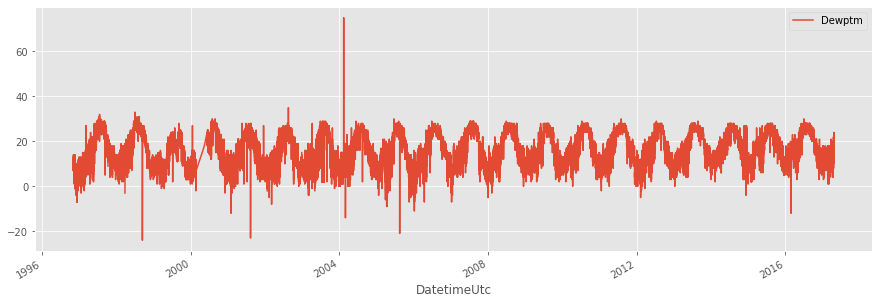

In [7]:
df.plot(figsize=(15,5),x='DatetimeUtc',y='Dewptm')
plt.show()

In [8]:
df['year']=df['DatetimeUtc'].dt.year
df['month']=df['DatetimeUtc'].dt.month

In [9]:
df=df.query('Dewptm>-20 and Dewptm <40')

In [10]:
grouped=df.groupby(['year','month'])['Dewptm'].mean().reset_index()
grouped

,year,month,Dewptm
0,1996,11,7.252475
1,1996,12,4.823890
2,1997,1,7.910078
3,1997,2,7.460432
4,1997,3,12.512963
...,...,...,...
240,2016,12,11.481707
241,2017,1,11.705975
242,2017,2,12.183594
243,2017,3,13.157233


In [35]:
train=grouped.iloc[:195,:]
test=grouped.iloc[195:,:]

xtrain, xtest,ytrain,ytest=train[['year','month']],test[['year','month']],train['Dewptm'],test['Dewptm']

In [36]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

model=XGBRegressor()

params={
    'learning_rate':[0.02,0.05,0.1],
    'max_depth':[2,3,5],
    'n_estimators':[1000,2000,5000]
}

gs=GridSearchCV(model,params,n_jobs=1,verbose=10)
gs.fit(xtrain,ytrain)

df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

In [37]:
#gs.best_params_
#learning_rate=0.02,max_depth=2,n_estimators=1000
#learning_rate=0.01,max_depth=5,n_estimators=2000

In [38]:
model=XGBRegressor(learning_rate=0.01,max_depth=5,n_estimators=2000)

In [39]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [40]:
train_prediction=model.predict(xtrain)
test_prediction=model.predict(xtest)

In [41]:
r2_train=metrics.r2_score(train_prediction,ytrain)
r2_test=metrics.r2_score(test_prediction,ytest)

mae_train=metrics.mean_absolute_error(train_prediction,ytrain)
mae_test=metrics.mean_absolute_error(test_prediction,ytest)

rmse_train=metrics.mean_squared_error(train_prediction,ytrain,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,ytest,squared=False)

print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.9425899867699892 0.9311006515889035
1.130064448785985 1.2558674900862323
1.4630025126787212 1.5874453531336317


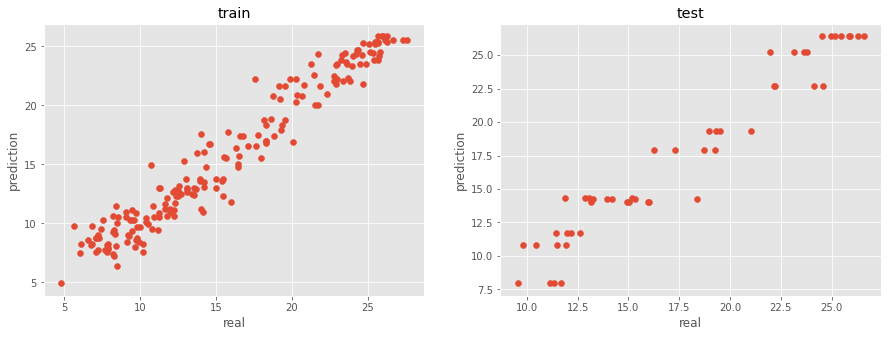

In [42]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(ytrain,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')

ax2.scatter(ytest,test_prediction)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

In [82]:
test['prediction']=test_prediction
test['period']=test['year'].astype(str)+'-'+test['month'].astype(str)
test['period']=pd.to_datetime(test['period'])

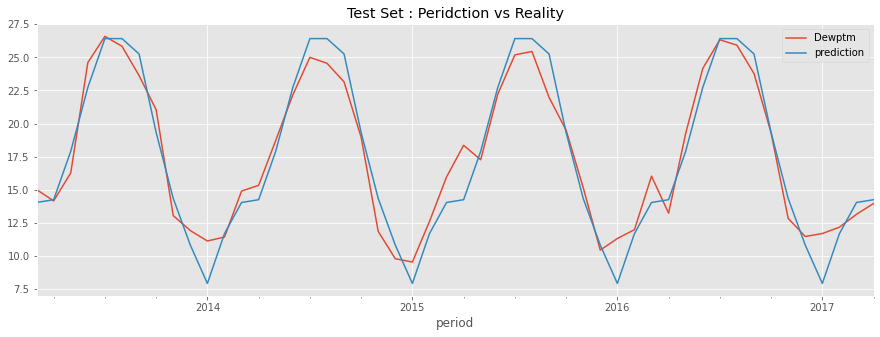

In [87]:
fig,ax=plt.subplots(figsize=(15,5))
test.plot(ax=ax,kind='line',x='period',y=['Dewptm','prediction'])
ax.set_title('Test Set : Peridction vs Reality')
plt.show()